# Nuclei Segmentation using U-Net

# Import Libraries

In [2]:
# Standard libararies
import os
import glob
import random
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Pytorch Libraries
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler

# Ensure Reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create Training Files

## Join multiple masks into a single mask

In [ ]:
def combine_masks(data_dir):
    for image_dir in os.listdir(data_dir):
        image_dir_path = os.path.join(data_dir, image_dir)
        mask_path = os.path.join(image_dir_path, 'masks')
        image_path = os.path.join(image_dir_path, 'images', image_dir+".png")
        og_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
        
        # Combined Mask
        new_mask_path = os.path.join(image_dir_path, 'mask')
        new_mask = np.zeros_like(og_img)
        
        if not os.path.exists(new_mask_path):
            os.makedirs(new_mask_path)
            
        for mask in os.listdir(mask_path):
            current_mask_path = os.path.join(mask_path, mask)
            img = cv2.cvtColor(cv2.imread(current_mask_path), cv2.COLOR_BGR2GRAY)
            idx = np.where(img == 255)
            new_mask[idx] = 255
        full_mask_path = os.path.join(new_mask_path, image_dir+".png")
        
        # Save combined mask
        cv2.imwrite(full_mask_path, new_mask)

Combine Masks into single masks
data_dir = "stage_1/train/"
combine_mask(data_dir)
print("Masks Combined.")

In [ ]:
def get_image_paths(data_dir, data_type):
    dataset = {}
    for image_dir in os.listdir(data_dir):
        image_dir_path = os.path.join(data_dir, image_dir)
        image_path = os.path.join(image_dir_path, 'images', image_dir+".png")
        mask_path = os.path.join(image_dir_path, 'mask', image_dir+".png")
        if(data_type == "train"):
            dataset[image_dir] = [image_path, mask_path]
        else:
            dataset[image_dir] = image_path

    return dataset

# Train Images
train_dir = 'stage_1/train/'
train_dict = get_image_paths(train_dir, "train")

# Test Images
test_dir = 'stage_1/test/'
test_dict = get_image_paths(test_dir, "test")

## Split Train and Validation Files

In [ ]:
# Create validation split
split_size = .10
random_seed = 7

random.seed(random_seed)
val_dict = dict(random.sample(list(train_dict.items()), int(len(train_dict)*split_size)))

train_dict = {key:value for key, value in train_dict.items() if key not in val_dict.keys()}

In [ ]:
# training text
with open("train_images.txt", 'w') as f:
    with open("train_labels.txt", 'w') as i:
        for key, value in train_dict.items():
            f.write(value[0])
            i.write(value[1])

            f.write("\n")
            i.write("\n")
                
# validation text
with open("val_images.txt", 'w') as f:
    with open("val_labels.txt", 'w') as i:
        for key, value in val_dict.items():
            f.write(value[0])
            i.write(value[1])

            f.write("\n")
            i.write("\n")

# test text
with open("test_images.txt", 'w') as f:
        for key, value in test_dict.items():
            f.write(value)

            f.write("\n")
            
print("Training Files created.")

# U-Net Model

In [3]:
"""
U-Net model and U-Net parts borrowed from https://github.com/milesial/Pytorch-UNet/tree/master/unet
"""

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Dataset

In [7]:
# Dataset class for training and validation sets
class NucleusDataset(Dataset):
    def __init__(self, mask_file, data_file, input_size):
        # Load Images
        with open(data_file) as f:
            self.image_paths = f.readlines()

        # Load Masks
        with open(mask_file) as f:
            self.mask_paths = f.readlines()

        self.image_paths = [x.strip() for x in self.image_paths]
        self.mask_paths = [x.strip() for x in self.mask_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        img = self.preprocess()(img)

        mask = cv2.cvtColor(cv2.imread(self.mask_paths[idx]), cv2.COLOR_BGR2GRAY)
        mask = self.preprocess_mask()(mask)
        return (img, mask, idx)
    
    def preprocess(self):
        """
        Preprocessing function for images. 
        Transforms: 
        Conver to PIL image
        Resize to specified size.
        Convert to grayscale.
        Convert to tensor
        """
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size, 3),
            transforms.ToTensor()
            ])
    
    def preprocess_mask(self):
        """
        Preprocessing function for masks. 
        Transforms: 
        Conver to PIL image
        Resize to specified size.
        Convert to grayscale.
        Convert to tensor
        """
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size, 3),
            transforms.Grayscale(),
            transforms.ToTensor()
            ])

# Dataset class for test set
class NucleusTestDataset(Dataset):
    def __init__(self, data_file, input_size):
        # Load Images
        with open(data_file) as f:
            self.image_paths = f.readlines()

        self.image_paths = [x.strip() for x in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        img = self.preprocess()(img)

        return (img, idx)
    
    def preprocess(self):
        """
        Preprocessing function for images. 
        Transforms: 
        Conver to PIL image
        Resize to specified size.
        Convert to grayscale.
        Convert to tensor
        """
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size, 3),
            transforms.ToTensor()
            ])

# Load Data

In [ ]:
# Input size for model
input_size = (256, 256)

# Create train and validation sets
train_images_file = "train_images.txt"
train_labels_file = "train_labels.txt"
val_images_file = "val_images.txt"
val_labels_file = "val_labels.txt"

# Initialise Datasets
train_set = NucleusDataset(train_labels_file, train_images_file, input_size)
val_set = NucleusDataset(val_labels_file, val_images_file, input_size)

# Batch size for training
batch_size = 32

# Random seed for dataloader
random_seed = 7

# Initialize Dataloaders
torch.manual_seed(random_seed)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
print("Data Loaded.")

Data Loaded.


# Get Sample

Model Input Shape:  torch.Size([32, 3, 256, 256])
Masks Shape:  torch.Size([32, 1, 256, 256])


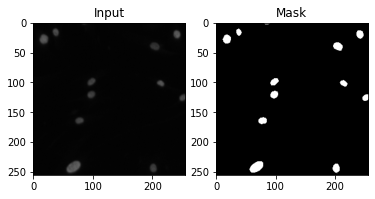

In [ ]:
def get_image_sample(data_loader):
    # Get Sample
    inputs, masks, idx = next(iter(data_loader))
    
    # Display Masks
    fig, axes = plt.subplots(1, 2)
    titles = ['Input', 'Mask']
    image_sets = [inputs[0], masks[0]]
    for i, axis in enumerate(axes):
        if(i == 0):
            axis.imshow(image_sets[i].squeeze(0).permute(1, 2, 0))
        else:
            axis.imshow(image_sets[i].squeeze(0), cmap = 'gray')
        axis.set_title(titles[i])

    print("Model Input Shape: ", inputs.shape)
    print("Masks Shape: ", masks.shape)

# Get Sample
get_image_sample(train_loader)

# Train Model

In [ ]:
def train(model, train_dataloader, val_dataloader, batch_size, num_epochs, learning_rate, patience, model_path, device):
    """
    Function to train a u-net model for segmentation.
    model: U-Net model
    Args:
        train_dataloader: training set
        val_dataloader: validation set
        batch_size: batch_size for training.
        num_epochs: number of epochs to train.
        learning_rate: learning rate for the optimiser
        patience: number of epochs for early stopping.
        model_path: checkpoint path to store the model.
        device: CPU or GPU to train the model.
    
    Returns: A dictionary containing the training and validation losses.
    """
    
    # Loss Collection
    train_losses  = []
    val_losses = []

    # Loss function
    if model.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    # Optimiser
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min' if model.n_classes > 1 else 'max', patience=patience)

    # Patience count
    count = 0

    for epoch in tqdm(range(1, num_epochs+1)):
        current_train_loss = 0.0
        current_val_loss = 0.0

        # Train model
        model.train()
        for features, labels, idx in train_dataloader:
            optimiser.zero_grad()
            features, labels = features.to(device), labels.to(device)
            output = model.forward(features)
            loss = criterion(output, labels)
            loss.backward()
            optimiser.step()
            current_train_loss += loss.item()

            del features, labels
            gc.collect()
            torch.cuda.empty_cache()
            
        # Evaluate model
        model.eval()
        with torch.no_grad():
            for features, labels, idx in val_dataloader:
                features, labels = features.to(device), labels.to(device)
                output = model.forward(features)
                loss = criterion(output, labels)
                current_val_loss += loss.item()

                del features, labels
                gc.collect()
                torch.cuda.empty_cache()
        
        # Store Losses
        current_train_loss /= len(train_dataloader)
        train_losses.append(current_train_loss)

        current_val_loss /= len(val_dataloader)
        val_losses.append(current_val_loss)

        print("Epoch: {0:d} -> Train Loss: {1:0.8f} Val Loss: {2:0.8f} ".format(epoch, current_train_loss, current_val_loss))
        if((epoch == 1) or (current_val_loss < best_val_loss)):
            best_val_loss = current_val_loss
            eq_train_loss = current_train_loss
            best_epoch = epoch
            count = 0

            # Save best model
            torch.save(model.state_dict(), model_path)
        
        # Check for patience level
        if(current_val_loss > best_val_loss):
            count += 1
            if(count == patience):
                break

    # Save best parameters
    best_model_params = {'train_losses': train_losses, 
                        'val_losses': val_losses, 
                        'best_val_loss': best_val_loss,
                        'eq_train_loss': eq_train_loss,
                        'best_epoch': best_epoch}
                             
    return best_model_params

In [ ]:
# Checkpoint path
output_dir = "experiment_test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
save_path = os.path.join(output_dir, "nucleus_unet.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initiliase Model
torch.manual_seed(random_seed)
model = UNet(n_channels = 3, n_classes = 1, bilinear = False).to(device)

# Hyperparameters
num_epochs = 100
learning_rate = 0.0001
patience = 10

# Train model
best_model_params = train(model, train_loader, val_loader, batch_size, num_epochs, 
                          learning_rate, patience, save_path, device)

Epoch: 1 -> Train Loss: 0.55332994 Val Loss: 0.72660244 
Epoch: 2 -> Train Loss: 0.40483249 Val Loss: 0.72720277 
Epoch: 3 -> Train Loss: 0.35987332 Val Loss: 0.36134559 
Epoch: 4 -> Train Loss: 0.33493435 Val Loss: 0.34030656 
Epoch: 5 -> Train Loss: 0.32134084 Val Loss: 0.30045288 
Epoch: 6 -> Train Loss: 0.30885437 Val Loss: 0.29246922 
Epoch: 7 -> Train Loss: 0.29628645 Val Loss: 0.29534885 
Epoch: 8 -> Train Loss: 0.28585447 Val Loss: 0.27676165 
Epoch: 9 -> Train Loss: 0.27875307 Val Loss: 0.29500241 
Epoch: 10 -> Train Loss: 0.26883098 Val Loss: 0.28413614 
Epoch: 11 -> Train Loss: 0.26066498 Val Loss: 0.25843882 
Epoch: 12 -> Train Loss: 0.25287098 Val Loss: 0.25525719 
Epoch: 13 -> Train Loss: 0.24732457 Val Loss: 0.24538794 
Epoch: 14 -> Train Loss: 0.23997430 Val Loss: 0.23742230 
Epoch: 15 -> Train Loss: 0.23115873 Val Loss: 0.23748256 
Epoch: 16 -> Train Loss: 0.22485340 Val Loss: 0.29627506 
Epoch: 17 -> Train Loss: 0.21936654 Val Loss: 0.23854148 
Epoch: 18 -> Train Loss

In [ ]:
print("Training complete.")

# Delete model to free memory
del model, best_model_params
gc.collect()
torch.cuda.empty_cache()

# Predict

In [24]:
# Get test set
test_file = "test_images.txt"
input_size = (256, 256)
torch.manual_seed(7)
test_set = NucleusTestDataset(test_file, input_size)
test_loader = DataLoader(test_set, batch_size = 1, sampler = RandomSampler(test_set))

# Inference device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Model
model_path = "experiment_test/nucleus_unet.pth"
model = UNet(n_channels = 3, n_classes = 1, bilinear = False).to(device)
model.load_state_dict(torch.load(model_path, map_location = device))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [33]:
# Predict Function
def predict_mask(input, threshold):
    output = model(input.to(device))
    output = torch.sigmoid(output).detach().cpu().numpy()
    pred = np.zeros_like(output)
    pred[np.where(output > threshold)] = 255

    return pred

# Threshold for prediction
threshold = 0.5

# Get test image
input, idx = next(iter(test_loader))

pred = predict_mask(input, threshold)

# Visualize

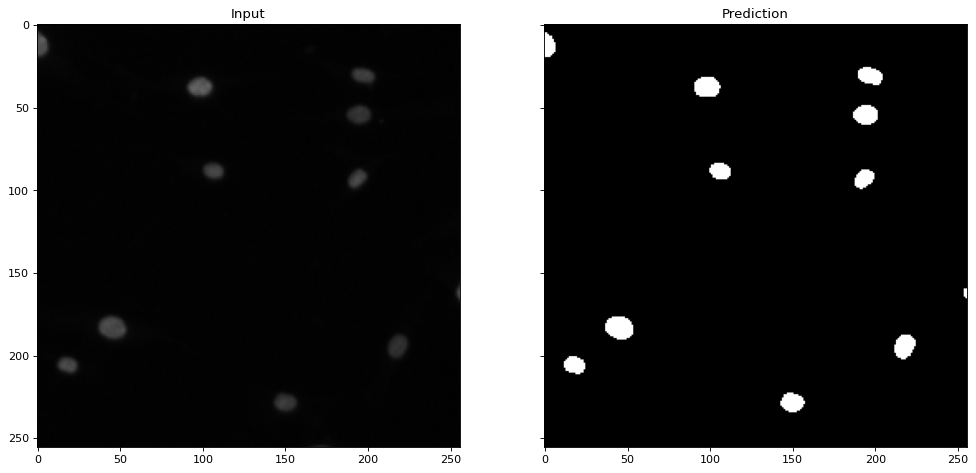

In [34]:
def visualize(input, pred):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)
    titles = ['Input', 'Prediction']
    image_sets = [input, pred]
    for i, axis in enumerate(axes):
        if (i == 0):
            img = image_sets[i].squeeze(0).permute(1, 2, 0)
        else:
            img = image_sets[i].squeeze(0).squeeze(0)
        axis.imshow(img, cmap = 'gray')
        axis.set_title(titles[i])


# Visualise Prediction
visualize(input, pred)